# Link Prediction Demo Notebook

This notebook demonstrates modern methods for link prediction using the **linkpredx** package.  
We focus on two core scenarios — **simulation** and **specific link prediction** — but also briefly describe the **discovery** setting.  

---

## 📖 Preamble

Graphs capture relationships between entities — people in a social network, proteins in biology, or products in an e-commerce system.  
The goal of **link prediction** is simple: given a graph where some connections are missing or hidden, can we guess which new links are the most likely to appear?  

Our package is designed with four key goals:  
1. **Ease of use** — a simple API for building datasets and training models.  
2. **High configurability** — flexible YAML configs to adjust splits, negatives, and features.  
3. **Multiple model support** — Random Forest, XGBoost, Logistic Regression, and Graph Neural Networks (GCN).  
4. **Structured evaluation** — test these models in a principled way through well-defined scenarios.  

This last goal is central: to make evaluation consistent and repeatable, we define **three scenarios** for dataset preparation and model testing.  

---
## 🛠️ Model Predictor (Meta-Learner)

On top of the scenarios and models, the package includes a **meta-learner**:  
- It computes high-level graph statistics (clustering, assortativity, degree variance, etc.).  
- Predicts **which model is best** for AUC and Top-K accuracy.  
- Provides expected scores, helping practitioners avoid exhaustive searches.  

---

## 📂 Outline of Scenarios

### 1. Simulation
- Randomly hide some edges to create a partially observed graph.  
- Train a model on this incomplete graph and test whether it can recover the missing edges.  
- **Use case:** benchmark algorithms under controlled train/test splits.  

### 2. Specific Links
- User provides a custom set of candidate node pairs.  
- Train on the observed graph and generate predictions only for those pairs.  
- **Use case:** hypothesis-driven questions like “will protein A interact with protein B?”  

### 3. Discovery
- Consider all non-edges (pairs of nodes with no link yet) as candidates.  
- Rank them by likelihood of forming a link in the future.  
- **Use case:** uncover novel connections (e.g., new friends, new drug–target interactions).  

---

## 🎯 What We’ll Cover in This Demo

- ✅ **Simulation**  
- ✅ **Specific Links**  
- ❌ **Discovery** (described, but not demonstrated here)  

---



## 🛠️ References 

**Author : Bisman Singh**  
- GitHub: [github.com/bis1999/edgepredict](https://github.com/bis1999/edgepredict)  
- Arxiv: [arxiv.org/abs/2508.09069](https://arxiv.org/abs/2508.09069)  


In [1]:
from IPython.display import display, HTML

# Disable scroll boxes for large outputs
display(HTML("<style>.output_scroll {height:auto !important; max-height:1000px;}</style>"))


# Cell 1: Setup and Network Creation [1 minute]
import warnings
warnings.filterwarnings('ignore')
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle 
from link_prediction.core.config import GeneratorConfig
from link_prediction.core.dataset_preparer import LinkPredictionDatasetPreparer
from link_prediction.core.trainer import LinkPredictionTrainer

### 📊 Loading and Visualizing the Network

We start with the **Norwegian Board of Directors** network:  

- **Nodes** represent individual directors.  
- **Edges** represent connections when two directors sit on the same board.  

This initial visualization gives us intuition about the network structure before we run any link prediction experiments.


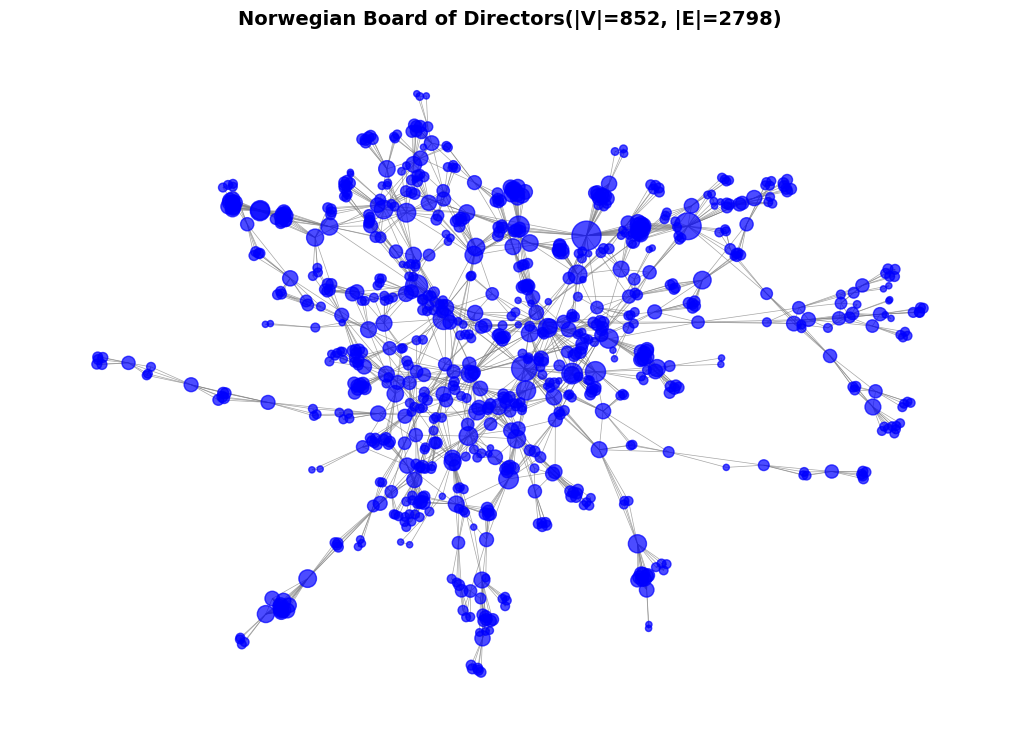

In [2]:
#Loading the networks 
with open("example_networks/norway_board.pkl", "rb") as f:
    lst_norway_net = pickle.load(f)
G = nx.Graph(lst_norway_net)
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
degrees = dict(G.degree())
node_sizes = [degrees[node]*10 for node in G.nodes()]

nx.draw(G, pos, node_size=node_sizes, node_color='blue', 
        alpha=0.7, edge_color='gray', width=0.5, with_labels=False)
plt.title(f"Norwegian Board of Directors(|V|={G.number_of_nodes()}, |E|={G.number_of_edges()})", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Stacked Model Training 

### ⚙️ Simulation Scenario Configuration

Before running the simulation, we define a **configuration object** that controls how the dataset is prepared.  
This makes the pipeline **reproducible and flexible** — we can run the same experiment on any graph just by changing these parameters.  

Key parameters in this demo:  

- **`obs_frac = 0.8`** → we keep 80% of edges in the observed graph (hide 20% for testing).  
- **`train_frac = 0.8`** → from the observed graph, we keep 80% of edges for training and hold out the rest.  
- **`n_folds = 3`** → perform 3-fold cross-validation on the training data.  
- **`train_neg_samples = 10000`** → number of negative (non-edge) samples added to the training set.  
- **`sim_ho_neg_samples = 10000`** → number of negative samples in the holdout set for evaluation.  

This structure means the package can flexibly adapt — for example, in one experiment we might hide 10% of edges, in another 30%, or change the number of negatives, all without rewriting the code.  


We’ll:
1) Build the observed (`G'`) and training (`G''`) graphs,  
2) Train on `G''`,  
3) Evaluate on the held-out edges (plus negatives) from `G'`.



In [3]:
import time

print("\n" + "="*60)
print("📊 SCENARIO 1: SIMULATION - Hidden Edge Recovery")
print("="*60)
print("Goal: Hide edges, train on remaining, try to recover hidden ones")

# Configure simulation
sim_config = GeneratorConfig(
                obs_frac           =0.8, 
                train_frac         =0.8,
                n_folds            =3,
                train_neg_samples  =10000, 
                sim_ho_neg_samples =10000
            )

print(f"Configuration: Hide {(1-sim_config.obs_frac)*100:.0f}% edges for testing")

# Prepare simulation data
sim_preparer = LinkPredictionDatasetPreparer(G, sim_config)
sim_result = sim_preparer.prepare_dataset(scenario="simulation")


📊 SCENARIO 1: SIMULATION - Hidden Edge Recovery
Goal: Hide edges, train on remaining, try to recover hidden ones
Configuration: Hide 20% edges for testing


### 📦 Training Stacked Models (Simulation)

Now that we’ve prepared the simulation dataset, we can train a set of **baseline models**.  
For this demo, we’ll compare:  

- **Random Forest** – a robust ensemble of decision trees.  
- **XGBoost** – a gradient boosting model optimized for speed and accuracy.  

We’ll evaluate them on:  
- **ROC-AUC** – ranking quality across all thresholds.  
- **Top-K (K=100)** – how many of the true links appear in the top 100 predictions.  
- **Training Time** – to understand efficiency.  

This gives us both **predictive performance** and **practical runtime comparisons**.


In [4]:


print(f" Prepred: {len(sim_result['df_tr_top'])} train, {len(sim_result['df_ho_top'])} test samples")
sim_trainer = LinkPredictionTrainer(sim_result)
# Train models for simulation

print("\n Training models for simulation...")


models_res = {}
for model in ['random_forest','xgboost']:
    models_res[model] = {}
    ml_start_time = time.time()
    sim_ml_results = sim_trainer.train_ml_models(
        models=[model],
        primary_metric="auc",
        ks=[100]
    )
    ml_training_time = time.time() - ml_start_time
    models_res[model]['ROC AUC']       =  sim_ml_results['holdout_metrics']['roc_auc']
    models_res[model]['Top-K(K=100)']  =  sim_ml_results['holdout_metrics']['precision@100']
    models_res[model]['Training Time'] =    ml_training_time
    
    

[INFO] link_prediction.core.trainer: Training ML models for simulation scenario
[INFO] link_prediction.models.ml_models: ML Trainer | folds=3 | features=20 | models=['random_forest']


 Prepred: 20000 train, 10560 test samples

 Training models for simulation...


[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.9947
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42} | auc=0.9947
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.9995
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42} | auc=0.9997
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.9950
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42} | auc=0.9950
[INFO] link_predic

## GNN Training 

### 🧠 Training a Graph Neural Network (GCN)

In addition to the baselines, we’ll also train a **Graph Neural Network (GNN)** — specifically, a **Graph Convolutional Network (GCN)**.  

Key points:  
 
- **Setup:** We train with cross-validation to avoid overfitting, and run for up to 400 epochs.  
- **Evaluation:** Just like the baselines, we’ll measure **ROC-AUC**, **Top-K (K=100)**, and **Training Time**.  



In [5]:
# GNN training 
gnn_training_time = 0
gnn_start_time = time.time()
sim_gnn_results = sim_trainer.train_gnn_model(
    model_type = 'gcn',
    use_cv=True,
    max_trials=2,
    cv_epochs=100,
    epochs=100,
    ks=[100]
)                
gnn_training_time = time.time() - gnn_start_time
models_res['gnn'] = {}
models_res['gnn']['ROC AUC'] =   sim_gnn_results['simulation_metrics']['roc_auc']
models_res['gnn']['Top-K(K=100)'] =  sim_gnn_results['simulation_metrics']['precision@100']
models_res['gnn']['Training Time'] =    gnn_training_time 

[INFO] link_prediction.core.trainer: Training GNN (GCN) for simulation scenario
[INFO] link_prediction.core.trainer: Using cross-validation for hyperparameter optimization
[INFO] link_prediction.models.gnn_trainer: Starting GNN hyperparameter optimization with 2 trials
[INFO] link_prediction.models.gnn_trainer: Sampling 2 from 480 possible combinations
GNN CV optimization:   0%|                                | 0/2 [00:00<?, ?it/s][INFO] link_prediction.models.gnn_trainer: Epoch    1 | loss 0.6931 | valAUC 0.5069
[INFO] link_prediction.models.gnn_trainer: Early stopping at epoch 33 (best valAUC=0.6866)
[INFO] link_prediction.models.gnn_trainer: Epoch    1 | loss 0.6931 | valAUC 0.5069
[INFO] link_prediction.models.gnn_trainer: Early stopping at epoch 33 (best valAUC=0.6866)
[INFO] link_prediction.models.gnn_trainer: Epoch    1 | loss 0.6931 | valAUC 0.5069
[INFO] link_prediction.models.gnn_trainer: Early stopping at epoch 33 (best valAUC=0.6866)
[INFO] link_prediction.models.gnn_traine

## All Models Score

### 📊 Benchmark Results Table

Now that we’ve trained all three models — **Random Forest**, **XGBoost**, and **GCN** — let’s compare them side by side.  

The table below summarizes their performance across three key metrics:  

- **ROC-AUC** → How well the model ranks positive edges over negatives across all thresholds.  
- **Top-K (K=100)** → How many true edges appear among the top 100 predictions.  
- **Training Time** → The total runtime to fit the model, useful for understanding efficiency.  

This comparison helps us balance **predictive power** with **computational cost** and highlights trade-offs between classical ML models and GNNs.


In [6]:
 benchmark_df = pd.DataFrame(models_res)
 benchmark_df 

,random_forest,xgboost,gnn
ROC AUC,0.998228,0.998866,0.934956
Top-K(K=100),0.990000,1.000000,0.580000
Training Time,9.572612,2.427310,15.493200


## Predicting Best Models

### 🧭 Model Recommendation with the Meta-Learner

Alongside training and benchmarking models directly, our package also includes a **meta-learner**.  
Instead of exhaustively running every model, the meta-predictor looks at high-level graph statistics  
(e.g., clustering, assortativity, degree variance from the **observed graph** and predicts:  

- The model most likely to perform best on **ROC-AUC**.  
- The model most likely to perform best on **Top-K accuracy**.  
- The expected performance scores for both metrics.  

This acts like a *model recommender system for link prediction*.  
It allows practitioners to quickly identify the right model family to start with, saving time and compute.


In [8]:

G = sim_result['graphs']['observed']
from link_prediction.prediction.graph_predictor import GraphPredictor
predictor = GraphPredictor()
recommendation = predictor.predict(G)


### 📊 Comparing Actual vs. Predicted Best Models

Now that we have both the **benchmark results** (from training Random Forest, XGBoost, and GCN)  
and the **meta-predictor’s recommendations**, we can compare them side by side.  

This table shows:  
- Which model actually achieved the best score for **ROC-AUC** and **Top-K (K=100)**.  
- The corresponding performance values.  
- The model recommended by the meta-predictor for each metric.  
- The meta-predictor’s expected scores.  

This lets us see how well the recommender aligns with reality — a quick validation that it provides useful guidance without having to train every model.


In [9]:
# Extract the actual best models from benchmark_df
actual_best_auc_model = benchmark_df.loc["ROC AUC"].idxmax()
actual_best_topk_model = benchmark_df.loc["Top-K(K=100)"].idxmax()

# Build comparison table
comparison_df = pd.DataFrame({
    "Metric": ["ROC AUC", "Top-K(K=100)"],
    "Actual Best Model": [actual_best_auc_model, actual_best_topk_model],
    "Actual Score": [
        benchmark_df.loc["ROC AUC", actual_best_auc_model],
        benchmark_df.loc["Top-K(K=100)", actual_best_topk_model]
    ],
    "Predicted Best Model": [
        recommendation["predicted_best_auc_model"], 
        recommendation["predicted_best_topk_model"]
    ],
    "Predicted Score": [
        recommendation["predicted_auc_score"], 
        recommendation["predicted_topk_score"]
    ],
})

# Display the styled comparison table
display(
    comparison_df.style
        .set_caption("Actual vs Predicted Best Models")
        .format(precision=4)
        .set_table_styles([
            {"selector": "caption", "props": [
                ("caption-side", "top"),
                ("font-size", "18pt"),
                ("font-weight", "bold"),
                ("text-align", "center")
            ]},
            {"selector": "table", "props": [
                ("font-size", "14pt"), 
                ("width", "80%")
            ]},
            {"selector": "th", "props": [
                ("font-size", "14pt"), 
                ("text-align", "center")
            ]},
            {"selector": "td", "props": [
                ("font-size", "13pt"), 
                ("text-align", "center")
            ]}
        ])
)


,Metric,Actual Best Model,Actual Score,Predicted Best Model,Predicted Score
0,ROC AUC,random_forest,0.9991,XGB_AUC,0.9949
1,Top-K(K=100),random_forest,1.0000,RF_Topk,0.9975


### 📊 Load & Visualize the Zachary Karate Club Network

We’ll start with the classic **Zachary Karate Club** graph:  
- **Nodes = club members**  
- **Edges = friendships/interactions**  




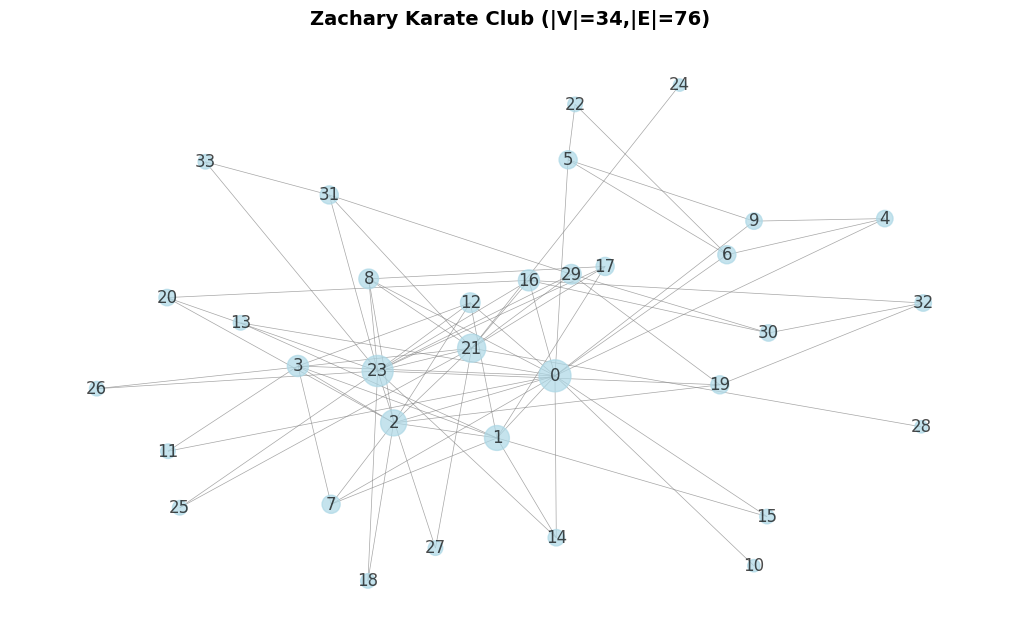

In [11]:
with open("example_networks/zachary_karate_club_net.pkl", "rb") as f:
    karate_net = pickle.load(f)
G = nx.Graph()
G.add_edges_from(karate_net)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
degrees = dict(G.degree())
node_sizes = [degrees[node] * 30 + 50 for node in G.nodes()]

nx.draw(G, pos, node_size=node_sizes, node_color='lightblue', 
        alpha=0.7, edge_color='gray', width=0.5, with_labels=True)
plt.title(f"Zachary Karate Club (|V|={G.number_of_nodes()},|E|={G.number_of_edges()})", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()


- Here, we **provide our own candidate pairs** to test.  
- For example, we’ll test connecting node `0` with nodes `17–33`.  
- The package will:  
  1. Prepare the observed and training graphs.  
  2. Sample negatives for balance.  
  3. Train a model (Random Forest in this case).  
  4. Output prediction scores for our chosen pairs.


In [12]:
print("\n" + "="*60)
print("🎯 SCENARIO 3: SPECIFIC - Targeted Edge Scoring")
print("="*60)
print("Goal: Score user-provided candidate pairs")


cand_edge = []
for i in range(17,34):
    cand_edge.append((0,i))
    

specific_candidates = cand_edge  

print(f"📋 Specific Candidates: {len(specific_candidates)} user-provided pairs")

# Configure specific scenario
spec_config = GeneratorConfig(
    obs_frac=0.9, train_frac=0.9, n_folds=2,
    train_neg_per_pos=2.0, random_state=42
)

# Prepare specific data
spec_preparer = LinkPredictionDatasetPreparer(G, spec_config)
spec_result = spec_preparer.prepare_dataset(
    scenario="specific", predict_edges=specific_candidates
)

# Train models for specific scoring
spec_trainer = LinkPredictionTrainer(spec_result)

print("\n Training models for specific scoring...")
spec_ml_results = spec_trainer.train_ml_models(
    models=["random_forest"],
    primary_metric="auc"
)

# Show specific scores
if 'candidate_predictions' in spec_ml_results:
    spec_preds = spec_ml_results['candidate_predictions'].sort_values('prediction_score', ascending=False)
    print(f"Specific Candidate Scores:")
    for i, (_, row) in enumerate(spec_preds.iterrows(), 1):
        print(f"      {i}. Pair ({int(row['u'])}, {int(row['v'])}): {row['prediction_score']:.3f}")

[INFO] link_prediction.core.trainer: Training ML models for specific scenario
[INFO] link_prediction.models.ml_models: ML Trainer | folds=2 | features=20 | models=['random_forest']
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.8438



🎯 SCENARIO 3: SPECIFIC - Targeted Edge Scoring
Goal: Score user-provided candidate pairs
📋 Specific Candidates: 17 user-provided pairs

 Training models for specific scoring...


[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42} | auc=0.8672
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.8438
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42} | auc=0.8672
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.8984
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42} | auc=0.8672
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.8984
[INFO] link_pred

Specific Candidate Scores:
      1. Pair (0, 30): 0.962
      2. Pair (0, 18): 0.961
      3. Pair (0, 20): 0.956
      4. Pair (0, 19): 0.952
      5. Pair (0, 32): 0.952
      6. Pair (0, 17): 0.944
      7. Pair (0, 22): 0.755
      8. Pair (0, 28): 0.593
      9. Pair (0, 24): 0.593
      10. Pair (0, 31): 0.573
      11. Pair (0, 33): 0.573
      12. Pair (0, 27): 0.570
      13. Pair (0, 26): 0.570
      14. Pair (0, 25): 0.570
      15. Pair (0, 29): 0.550
      16. Pair (0, 21): 0.498
      17. Pair (0, 23): 0.482


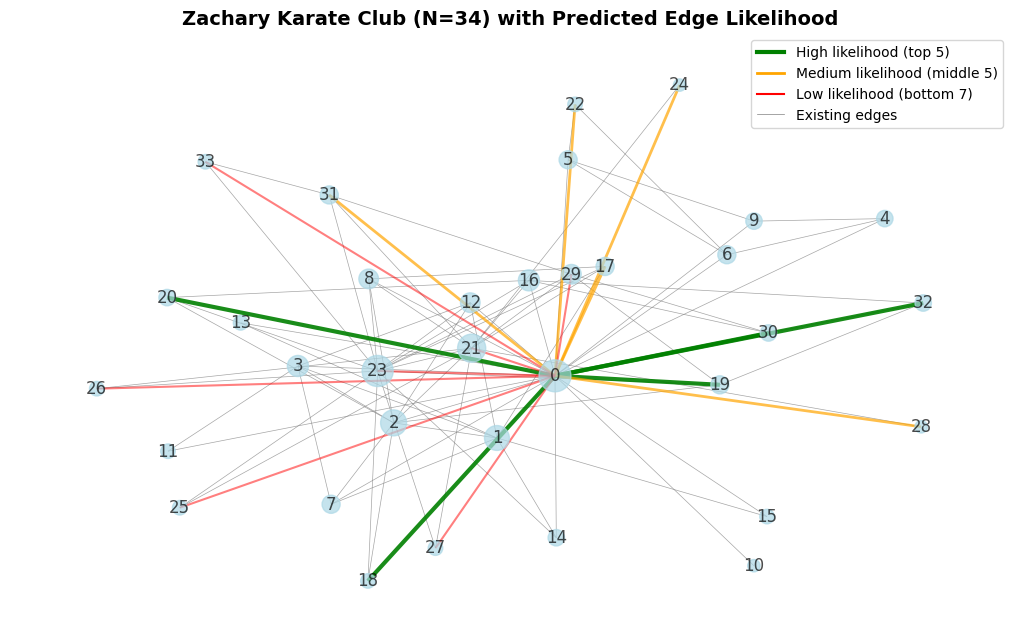


Predicted Edge Results:
GREEN (High likelihood):
   1. Edge (0, 30): 0.962
   2. Edge (0, 18): 0.961
   3. Edge (0, 20): 0.956
   4. Edge (0, 19): 0.952
   5. Edge (0, 32): 0.952

ORANGE (Medium likelihood):
   1. Edge (0, 17): 0.944
   2. Edge (0, 22): 0.755
   3. Edge (0, 28): 0.593
   4. Edge (0, 24): 0.593
   5. Edge (0, 31): 0.573

RED (Low likelihood):
   1. Edge (0, 33): 0.573
   2. Edge (0, 27): 0.570
   3. Edge (0, 26): 0.570
   4. Edge (0, 25): 0.570
   5. Edge (0, 29): 0.550
   6. Edge (0, 21): 0.498
   7. Edge (0, 23): 0.482


In [13]:
# Add this after your existing network visualization and ML prediction code

# Overlay predicted edges with color coding
if 'candidate_predictions' in spec_ml_results:
    spec_preds = spec_ml_results['candidate_predictions'].sort_values('prediction_score', ascending=False)
    
    # Create the same layout as your original plot
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
    degrees = dict(G.degree())
    node_sizes = [degrees[node] * 30 + 50 for node in G.nodes()]
    
    # Draw the base network (same as original)
    nx.draw(G, pos, node_size=node_sizes, node_color='lightblue', 
            alpha=0.7, edge_color='gray', width=0.5, with_labels=True)
    
    # Define color scheme for prediction scores
    n_edges = len(spec_preds)
    top_third = n_edges // 3
    
    # Color code the predicted edges
    for i, (_, row) in enumerate(spec_preds.iterrows()):
        edge = (int(row['u']), int(row['v']))
        score = row['prediction_score']
        
        if i < top_third:  # Top third - Green (high likelihood)
            color = 'green'
            width = 3
            alpha = 0.9
        elif i < 2 * top_third:  # Middle third - Orange (medium likelihood) 
            color = 'orange'
            width = 2
            alpha = 0.7
        else:  # Bottom third - Red (low likelihood)
            color = 'red'
            width = 1.5
            alpha = 0.5
        
        # Draw individual edge
        nx.draw_networkx_edges(G, pos, edgelist=[edge], 
                              edge_color=color, width=width, alpha=alpha)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=3, label=f'High likelihood (top {top_third})'),
        Line2D([0], [0], color='orange', lw=2, label=f'Medium likelihood (middle {top_third})'),
        Line2D([0], [0], color='red', lw=1.5, label=f'Low likelihood (bottom {n_edges - 2*top_third})'),
        Line2D([0], [0], color='gray', lw=0.5, label='Existing edges')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(f"Zachary Karate Club (N={G.number_of_nodes()})", fontsize=14, fontweight='bold')
    
    plt.title(f"Zachary Karate Club (N={G.number_of_nodes()}) with Predicted Edge Likelihood", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    # Print the color-coded results
    print(f"\nPredicted Edge Results:")
    print("GREEN (High likelihood):")
    for i, (_, row) in enumerate(spec_preds.head(top_third).iterrows(), 1):
        print(f"   {i}. Edge ({int(row['u'])}, {int(row['v'])}): {row['prediction_score']:.3f}")
    
    print("\nORANGE (Medium likelihood):")
    for i, (_, row) in enumerate(spec_preds.iloc[top_third:2*top_third].iterrows(), 1):
        print(f"   {i}. Edge ({int(row['u'])}, {int(row['v'])}): {row['prediction_score']:.3f}")
    
    print("\nRED (Low likelihood):")
    for i, (_, row) in enumerate(spec_preds.tail(n_edges - 2*top_third).iterrows(), 1):
        print(f"   {i}. Edge ({int(row['u'])}, {int(row['v'])}): {row['prediction_score']:.3f}")

else:
    print("No candidate predictions available for visualization")

## Discovery Mode


## Discovery Mode: Finding Missing Links

Discovery mode is designed to identify potential new connections in your existing network. Unlike simulation mode (which tests on held-out edges), discovery mode evaluates **non-edges** - pairs of nodes that aren't currently connected but potentially should be.

### How Discovery Mode Works

1. **Training Data**: Uses a subset of existing edges to learn connection patterns
2. **Candidates**: Samples non-edges (unconnected pairs) as potential new links  
3. **Scoring**: Applies trained models to score how likely each candidate should be connected
4. **Ranking**: Returns candidates sorted by prediction confidence

### Key Configuration Parameters

- `obs_frac`: Fraction of edges used for training graph (0.8 = 80%)
- `train_frac`: Fraction of observed edges for model training (0.8 = 80%) 
- `max_negative_samples`: Maximum candidate edges to evaluate (controls runtime)
- `n_folds`: Cross-validation folds for model selection

### Use Cases

- **Social Networks**: Find people who should connect
- **Collaboration Networks**: Identify potential partnerships
- **Recommendation Systems**: Suggest items users might like
- **Knowledge Graphs**: Discover missing relationships
- **Infrastructure Planning**: Identify beneficial new connections

### Interpreting Results

Higher prediction scores indicate stronger confidence that the edge should exist. The model learns from existing network structure, node features, and connectivity patterns to make predictions.

In [14]:
# 2. Configure for discovery
config = GeneratorConfig(
    obs_frac=0.8,                    # Use 80% of edges for training
    train_frac=0.8,                  # Use 80% of observed for training
    max_negative_samples=1000,       # Evaluate 5000 potential edges
    n_folds=3,                       # Quick 3-fold CV
    random_state=42
)

# 3. Prepare discovery dataset
preparer = LinkPredictionDatasetPreparer(G, config)
results = preparer.prepare_dataset("discovery")

print(f"Training samples: {len(results['df_tr_top'])}")
print(f"Candidate edges to evaluate: {len(results['df_ho_top'])}")

# 4. Train models to score candidates
trainer = LinkPredictionTrainer(results)
ml_results = trainer.train_ml_models(
    models=['random_forest'],  # Quick single model
    ks=[10, 20]
)

print(f"Best model: {ml_results['best_summary']['best_model']}")
print(f"CV Score: {ml_results['best_summary']['best_score']:.4f}")

# 5. Get predictions for candidate edges
if 'candidate_predictions' in ml_results:
    candidates = ml_results['candidate_predictions']
    
    # Show top 10 predicted edges
    top_10 = candidates.nlargest(10, 'prediction_score')
    print("\nTop 10 predicted new edges:")
    print("Rank | Edge  | Score")
    print("-----|-------|-------")
    
    for i, (_, row) in enumerate(top_10.iterrows(), 1):
        u, v = int(row['u']), int(row['v'])
        score = row['prediction_score']
        print(f" {i:2d}  | ({u:2d},{v:2d}) | {score:.3f}")

[INFO] link_prediction.core.trainer: Training ML models for discovery scenario
[INFO] link_prediction.models.ml_models: ML Trainer | folds=3 | features=20 | models=['random_forest']


Training samples: 96
Candidate edges to evaluate: 485


[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.9271
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42} | auc=0.9193
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.9388
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42} | auc=0.9193
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 2, 'n_jobs': -1, 'random_state': 42} | auc=0.9362
[INFO] link_prediction.models.ml_models: random_forest {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42} | auc=0.9271
[INFO] link_predic

Best model: random_forest
CV Score: 0.9421

Top 10 predicted new edges:
Rank | Edge  | Score
-----|-------|-------
  1  | (21,30) | 0.883
  2  | (23,32) | 0.843
  3  | (23,30) | 0.843
  4  | (19,21) | 0.803
  5  | (10,21) | 0.797
  6  | ( 0,23) | 0.790
  7  | ( 2,17) | 0.787
  8  | ( 2,29) | 0.787
  9  | ( 0,21) | 0.777
 10  | ( 0,22) | 0.763
